In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np
from PIL import Image

import tensorflow as tf
#tf.enable_eager_execution()
#import tensorflow.contrib.eager as tfe
import sys
import os
from sklearn.utils import shuffle
from random import sample
# from cache import cache
# import pydot
# import graphviz
# from sklearn.model_selection import train_test_split
import time
import pickle
from tqdm import tqdm
# import copy
# import re
# import random
import requests

In [2]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, Dropout, Activation, Flatten, Reshape, \
BatchNormalization, GlobalAveragePooling2D, Conv2D
from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.applications.vgg16 import preprocess_input as VGG16_preprocess_input
from tensorflow.python.keras.applications.inception_v3 import InceptionV3
from tensorflow.python.keras.applications.inception_v3 import preprocess_input
from tensorflow.python.keras.applications.inception_v3 import decode_predictions
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard
#from tensorflow.python.keras.utils import plot_model
#from tensorflow.python.keras.utils import to_categorical

In [3]:
tf.__version__

'2.1.0'

In [4]:
tf.keras.__version__

'2.2.4-tf'

In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9412496019269643692
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 1402284396844752833
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 166152630075567611
physical_device_desc: "device: XLA_GPU device"
]


In [6]:
print(tf.test.is_built_with_cuda())

True


# Load Data for Modeling

In [7]:
# get data from json
with open("data/caltech_images_20190919.json", 'r') as f:
    annotations = json.load(f)

annot_df = pd.DataFrame.from_dict(annotations['annotations'])
image_df = pd.DataFrame.from_dict(annotations['images'])

# get animal name map 
category_id = []
category_name = []

for i in annotations['categories']:
    category_id.append(i['id'])
    category_name.append(i['name'])
    
category_dict = dict(zip(category_id, category_name))
annot_df['category_name'] = annot_df['category_id'].map(category_dict)

# drop duplicate annotations
annot_df.sort_values("image_id", inplace = True) 
annot_df_nodup = annot_df.drop_duplicates(subset ="image_id", keep = 'first')

# merge annotation and image data together
image_df.rename(columns={"id": "image_id"}, inplace=True)
image_df.sort_values("image_id", inplace = True) 
image_df_annot = pd.concat([image_df.set_index('image_id'), annot_df_nodup.set_index('image_id')], axis=1, join='inner').reset_index()

image_df_annot.head()

,image_id,seq_num_frames,date_captured,seq_id,height,width,location,rights_holder,file_name,frame_num,id,category_id,category_name
0,5858bf1e-23d2-11e8-a6a3-ec086b02610b,1,2014-07-10 14:20:20,6fc5ac4a-5567-11e8-b3db-dca9047ef277,1494,2048,96,Erin Boydston,test/5858bf1e-23d2-11e8-a6a3-ec086b02610b.jpg,1,52acca15-7d6d-11e7-884d-7845c41c2c67,30,empty
1,5858bf20-23d2-11e8-a6a3-ec086b02610b,1,2014-05-26 13:44:00,6fbb3c73-5567-11e8-b378-dca9047ef277,1494,2048,96,Erin Boydston,test/5858bf20-23d2-11e8-a6a3-ec086b02610b.jpg,1,f77c64a8-7d6e-11e7-884d-7845c41c2c67,30,empty
2,5858bf21-23d2-11e8-a6a3-ec086b02610b,1,2014-09-16 08:16:51,7006f717-5567-11e8-b4c6-dca9047ef277,1494,2048,114,Erin Boydston,test/5858bf21-23d2-11e8-a6a3-ec086b02610b.jpg,1,1aa83e59-7d71-11e7-884d-7845c41c2c67,10,rabbit
3,5858bf22-23d2-11e8-a6a3-ec086b02610b,1,2014-05-27 14:57:44,6fbd60e3-5567-11e8-a122-dca9047ef277,1494,2048,96,Erin Boydston,test/5858bf22-23d2-11e8-a6a3-ec086b02610b.jpg,1,45913ae8-7d6d-11e7-884d-7845c41c2c67,30,empty
4,5858bf23-23d2-11e8-a6a3-ec086b02610b,1,2014-06-06 12:31:06,6fbf5a47-5567-11e8-9655-dca9047ef277,1494,2048,96,Erin Boydston,test/5858bf23-23d2-11e8-a6a3-ec086b02610b.jpg,1,5f7e6e7a-7d6e-11e7-884d-7845c41c2c67,30,empty


# Show Image

In [8]:
def load_image(path, size=None):
    """
    Load the image from the given file-path and resize it
    to the given size if not None.
    """

    # Load the image using PIL.
    img = Image.open(path)

    # Resize image if desired.
    if not size is None:
        img = img.resize(size=size, resample=Image.LANCZOS)

    # Convert image to numpy array.
    img = np.array(img)

    # Scale image-pixels so they fall between 0.0 and 1.0
    img = img / 255.0

    # Convert 2-dim gray-scale array to 3-dim RGB array.
    if (len(img.shape) == 2):
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

    return img

def show_image(path, category):
    """
    Load and plot an image from the training- or validation-set
    with the given index.
    """

    #path = filenames_train[idx]
    #caption = captions_train[idx]

    # Print the captions for this image.
    print("Category: " + category)
    
    # Load the image and plot it.
    img = load_image(path)
    plt.imshow(img)
    plt.show()
    
def show_image_by_category(images=1, category = 'any'):
    path = 'data/cct_images/'
    if category == 'any':
        samples = image_df_annot.sample(n=images)
    else:
        samples = image_df_annot[image_df_annot['category_name']==category].sample(n=images)
    for id, sample in samples.iterrows():
        image_id = sample['image_id']
        filename= 'data/cct_images/'+image_id + '.jpg'
        print(sample['category_name'] + " " + image_id)
        img = load_image(filename)
        plt.imshow(img)
        plt.show()    

# Define Prediction Class

In [10]:
classes = ['rodent','squirrel','rabbit','bird','deer','raccoon','coyote','opossum']
classes_dict = dict(zip(classes + ['other'] + ['empty'], range(10)))
classes_dict_lookup = dict(zip(range(10), classes + ['other'] + ['empty']))

In [11]:
classes_dict

{'rodent': 0,
 'squirrel': 1,
 'rabbit': 2,
 'bird': 3,
 'deer': 4,
 'raccoon': 5,
 'coyote': 6,
 'opossum': 7,
 'other': 8,
 'empty': 9}

In [12]:
orig_class = list(image_df_annot['category_name'].unique())
new_class = [animal if animal in classes + ['empty'] else 'other' for animal in orig_class]
prediction_class_map = dict(zip(orig_class, new_class))

In [13]:
prediction_class_map

{'empty': 'empty',
 'rabbit': 'rabbit',
 'bobcat': 'other',
 'squirrel': 'squirrel',
 'raccoon': 'raccoon',
 'coyote': 'coyote',
 'bird': 'bird',
 'car': 'other',
 'opossum': 'opossum',
 'cow': 'other',
 'skunk': 'other',
 'dog': 'other',
 'deer': 'deer',
 'fox': 'other',
 'cat': 'other',
 'rodent': 'rodent',
 'mountain_lion': 'other',
 'lizard': 'other',
 'badger': 'other',
 'insect': 'other',
 'pig': 'other',
 'bat': 'other'}

In [14]:
image_df_annot['category_name_model'] = image_df_annot['category_name'].map(prediction_class_map)
image_df_annot['category_id_model'] = image_df_annot['category_name'].map(classes_dict)
image_df_annot = image_df_annot.sample(frac=1, random_state=1)

In [15]:
image_df_annot.groupby('category_name_model').image_id.count().sort_values()

category_name_model
rodent        4272
squirrel      4432
bird          9521
raccoon      10981
deer         12191
rabbit       12345
coyote       16348
opossum      16634
other        30631
empty       125745
Name: image_id, dtype: int64

# Data Partition by Location

In [9]:
# download suggested split from data website
url = 'https://lilablobssc.blob.core.windows.net/caltechcameratraps/CaltechCameraTrapsSplits_v0.json'
split = requests.get(url).json()

# use suggested split for test
train_val_loc = sorted(list(set(split['splits']['train'])))
test_loc = sorted(list(set(split['splits']['val'])))

# furthur split training and validation
train_val_loc = shuffle(train_val_loc, random_state=2)
train_loc = train_val_loc[:60]
val_loc = train_val_loc[60:]

In [16]:
data_train = image_df_annot[image_df_annot['location'].isin(train_loc)]
data_val = image_df_annot[image_df_annot['location'].isin(val_loc)]
data_test = image_df_annot[image_df_annot['location'].isin(test_loc)]

In [17]:
print(data_train.shape)
print(data_val.shape)
print(data_test.shape)

(115212, 15)
(65478, 15)
(62410, 15)


In [18]:
# get image vector
img_vector_train = list('data/cct_images/' + data_train['image_id'] + '.jpg')
img_vector_val = list('data/cct_images/' + data_val['image_id'] + '.jpg')
img_vector_test = list('data/cct_images/' + data_test['image_id'] + '.jpg')

In [19]:
# get category vector
cat_name_vector_train = list(data_train['category_name_model'])
cat_id_vector_train = list(data_train['category_id_model'])

cat_name_vector_val = list(data_val['category_name_model'])
cat_id_vector_val = list(data_val['category_id_model'])

cat_name_vector_test = list(data_test['category_name_model'])
cat_id_vector_test = list(data_test['category_id_model'])

Category: deer


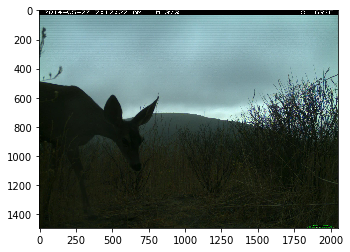

In [20]:
id = 5
show_image(img_vector_train[id], cat_name_vector_train[id])

# Encode Images with InceptionV3 For Faster Training

In [21]:
# Get the InceptionV3 model trained on imagenet data
inception_v3 = InceptionV3(weights='imagenet')

# Take -3 layer with shape (8,8,2048)
inception_v3_body = Model(inception_v3.input, inception_v3.layers[-3].output)

In [22]:
inception_v3_body.output

<tf.Tensor 'mixed10/Identity:0' shape=(None, 8, 8, 2048) dtype=float32>

In [23]:
def load_image_for_inception(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = preprocess_input(img)
    return img, image_path

In [ ]:
image_dataset = tf.data.Dataset.from_tensor_slices(img_vector_train)
image_dataset = image_dataset.map(load_image_for_inception, 
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

for img, path in tqdm(image_dataset):
    batch_features = inception_v3_body(img)
    #batch_features = tf.reshape(batch_features,(tf.shape(batch_features)[0], -1, tf.shape(batch_features)[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8").replace('cct_images','test')
        np.save(path_of_feature, bf.numpy())
        
# 115212 images, 64 batch size, expect 1801 batches

In [ ]:
image_dataset = tf.data.Dataset.from_tensor_slices(img_vector_val)
image_dataset = image_dataset.map(load_image_for_inception, 
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

for img, path in tqdm(image_dataset):
    batch_features = inception_v3_body(img)
    #batch_features = tf.reshape(batch_features,(tf.shape(batch_features)[0], -1, tf.shape(batch_features)[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8").replace('cct_images','test')
        np.save(path_of_feature, bf.numpy())
        
# 65478 images, 64 batch size, expect 1024 batches

In [ ]:
image_dataset = tf.data.Dataset.from_tensor_slices(img_vector_test)
image_dataset = image_dataset.map(load_image_for_inception, 
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

for img, path in tqdm(image_dataset):
    batch_features = inception_v3_body(img)
    #batch_features = tf.reshape(batch_features,(tf.shape(batch_features)[0], -1, tf.shape(batch_features)[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8").replace('cct_images','test')
        np.save(path_of_feature, bf.numpy())
        
# 62410 images, 64 batch size, expect 976 batches

# Modeling - Transfer Learning with InceptionV3

In [ ]:
# take InceptionV3 without last layer
# model_transfer = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

In [ ]:
# add new trainable last layer and build model
transfer_input = Input(shape=(8,8,2048))
#x = Conv2D(1024, (3, 3), padding='same', activation='relu')(transfer_input)
#x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
x = GlobalAveragePooling2D()(transfer_input)
x = Dropout(0.2)(x)
#x = BatchNormalization()(x)
x = Dense(256, activation="relu")(x)
#x = BatchNormalization()(x)
x = Dense(15, activation="softmax")(x)
model = Model(transfer_input, x)

In [ ]:
model.summary()

In [ ]:
# compile model
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

### Generator Functions

In [ ]:
def load_encoding(path):
    return np.load(path.replace('cct_images', 'test') + '.npy')

In [ ]:
def generator_encoded(X_data, y_data, batch_size):
    i = 0
    while True:
        X_batch = []
        y_batch = []
        
        for b in range(batch_size):
            if i >= len(X_data):
                i = 0
                
            X = load_encoding(X_data[i])
            y = y_data[i]
            X_batch.append(X)
            y_batch.append(y)
            i += 1
            
        yield np.array(X_batch), np.array(y_batch)

### Train Model

In [ ]:
# test on 1024 images
sample_x_train = img_vector_train[:2048]
sample_y_train = cat_id_vector_train[:2048]

sample_x_val = img_vector_val[:64]
sample_y_val = cat_id_vector_val[:64]

In [ ]:
# train model with encoded data - much faster
# full data
EPOCH = 10
BATCH_SIZE = 64
TRAIN_STEPS = len(img_vector_train)//BATCH_SIZE
VAL_STEPS = len(img_vector_val)//BATCH_SIZE

train_generator = generator_encoded(img_vector_train, cat_id_vector_train, BATCH_SIZE)
val_generator = generator_encoded(img_vector_val, cat_id_vector_val, BATCH_SIZE)

for i in range(EPOCH):
    model.fit_generator(generator=train_generator, \
                        validation_data=val_generator,\
                        validation_steps=VAL_STEPS, \
                        steps_per_epoch=TRAIN_STEPS, \
                        epochs=1, verbose=1,\
                        use_multiprocessing=True)
    model.save('./weights/model_1/model_' + str(i) + '.h5')

# Prediction on Test Set

In [ ]:
predicted_id = []
predicted_name = []
for i in img_vector_test:
    pred_id = model.predict(load_encoding(i).reshape(1, 8, 8, 2048))
    pred_name = classes_dict_lookup[pred_id.argmax()]
    predicted_id.append(pred_id)
    predicted_name.append(pred_name)

# save prediction
with open('data/predicted_id.pkl', 'wb') as f:
    pickle.dump(predicted_id, f)
with open('data/predicted_name.pkl', 'wb') as f:
    pickle.dump(predicted_name, f)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
evaluation1 = precision_recall_fscore_support(cat_name_vector_test, predicted_name, average='macro')
evaluation2 = precision_recall_fscore_support(cat_name_vector_test, predicted_name, average='weighted')

In [ ]:
print(evaluation1)
print(evaluation2)